# Run IDF

In [1]:
import sys
from pathlib import Path

# Find the nearest directory that has a "src" folder (works no matter where you run the notebook)
here = Path.cwd()
src_dir = next(p for p in [here, *here.parents] if (p / "src").exists()) / "src"
sys.path.insert(0, str(src_dir))

In [ ]:
from tqdm import tqdm
# from ReIDF import run_IDF

# idf_files = ['../_base/idf/HVACDetailed-Jul.idf']
idf_files = ['ref/HVACDetailed-Jul.idf']
weather_file = '../_base/epw/ED-TMYx.2023.epw'
energyplus_exe = 'C:/EnergyPlusV23-2-0/EnergyPlus'

output_folders = []
for idf_file in tqdm(idf_files, desc="E+ running", unit=".idf file"):
    output_folder = run_IDF(idf_file, weather_file, energyplus_exe=energyplus_exe)
    output_folders.append(output_folder)

E+ running:   0%|          | 0/1 [00:00<?, ?.idf file/s]

# Plot HeatBalance
https://unmethours.com/question/20720/energy-plus-calculate-zone-energy-balance-manually/

# Validation
2029.477185	1790.84028	0	-20222.56028	0	16410.03146	4.99013263


In [1]:
%matplotlib inline
import pandas as pd
from __pltReIDF import (
    load_long, compute_aggs, get_df, plot_heat_balance,
    build_zone_meta_from_csvs, build_global_heatbalance_colormap)
areas = None  # optional
eplusout_path= "../_base/idf/HVACDetailed-Jul/eplusout.csv"

zone_meta, _ = build_zone_meta_from_csvs(
    summary_csv="ref/zones_by_floor_summary.csv",
    areas_csv="ref/zone_areas.csv",
    mode="primary"   # or "primary"
)
long_df = load_long(eplusout_path, assume_year=2021, zone_meta_df=zone_meta)
aggs = compute_aggs(long_df)

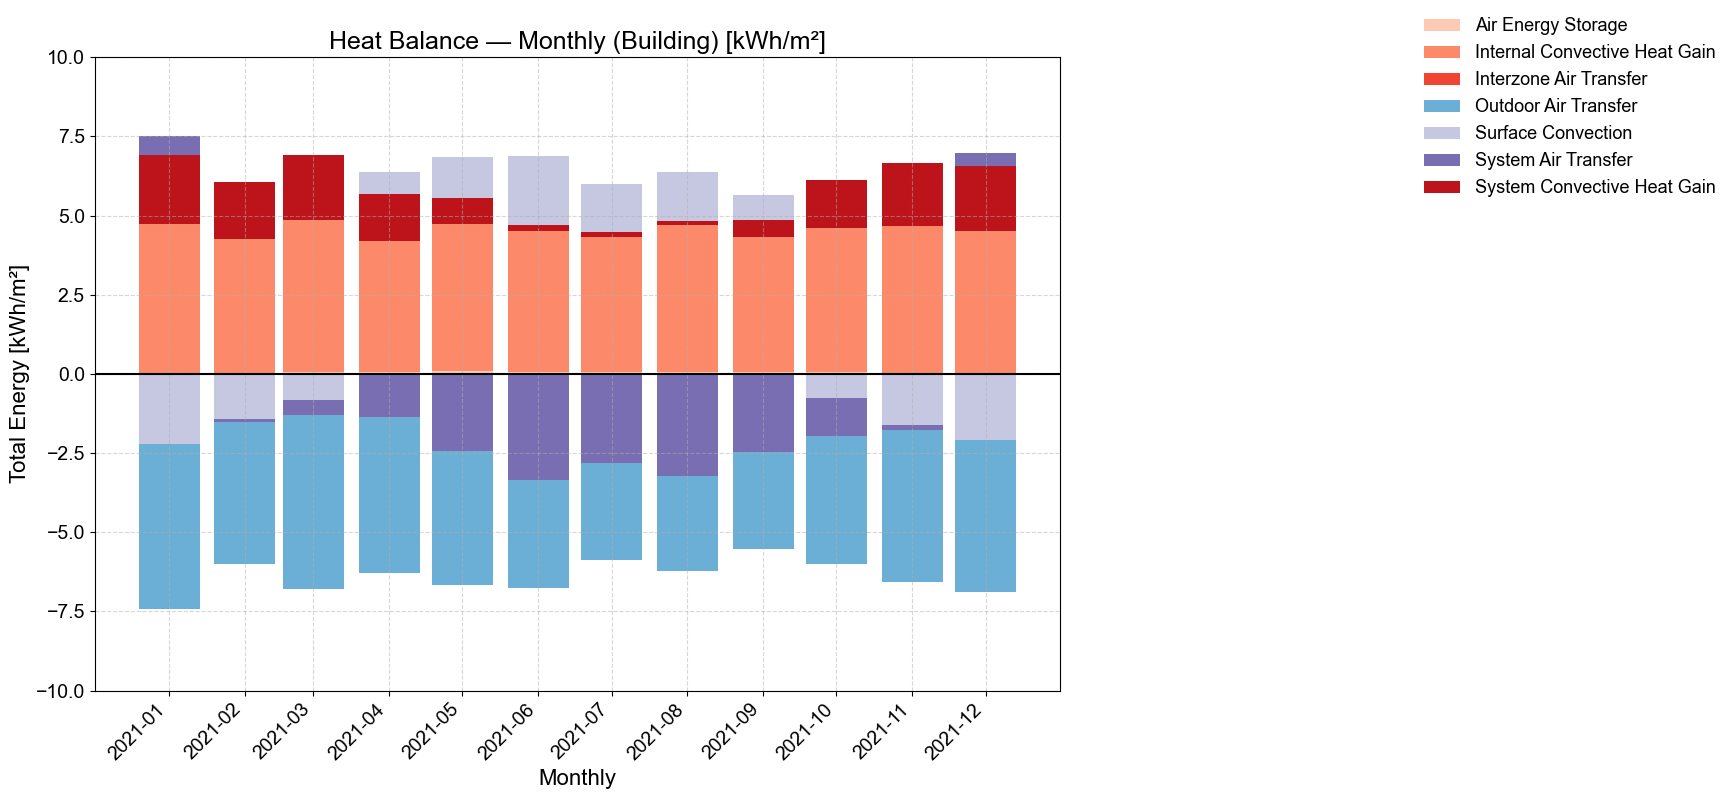

In [ ]:
global_colors = build_global_heatbalance_colormap(long_df)

# Building plot
df_bldg = get_df(aggs, scale="monthly", scope="building", units="kWh", per_m2=True, long_df_for_area=long_df)

plot_heat_balance(df_bldg, scale="monthly", scope="building",
                  units="kWh", per_m2=True, global_color_map=global_colors)


In [ ]:
df_bldg = get_df(aggs, scale="yearly", scope="building", units="kWh", per_m2=True, long_df_for_area=long_df)

,Month,Variable,Value,Value_per_m2
0,2021-01,Zone Air Heat Balance Air Energy Storage Rate ...,361.644066,0.037672
1,2021-01,Zone Air Heat Balance Internal Convective Heat...,45066.977959,4.694584
2,2021-01,Zone Air Heat Balance Interzone Air Transfer R...,0.000000,0.000000
3,2021-01,Zone Air Heat Balance Outdoor Air Transfer Rat...,-50296.192236,-5.239307
4,2021-01,Zone Air Heat Balance Surface Convection Rate ...,-21127.557270,-2.200838
...,...,...,...,...
79,2021-12,Zone Air Heat Balance Interzone Air Transfer R...,0.000000,0.000000
80,2021-12,Zone Air Heat Balance Outdoor Air Transfer Rat...,-46076.673943,-4.799764
81,2021-12,Zone Air Heat Balance Surface Convection Rate ...,-20162.795127,-2.100339
82,2021-12,Zone Air Heat Balance System Air Transfer Rate...,3841.751362,0.400192


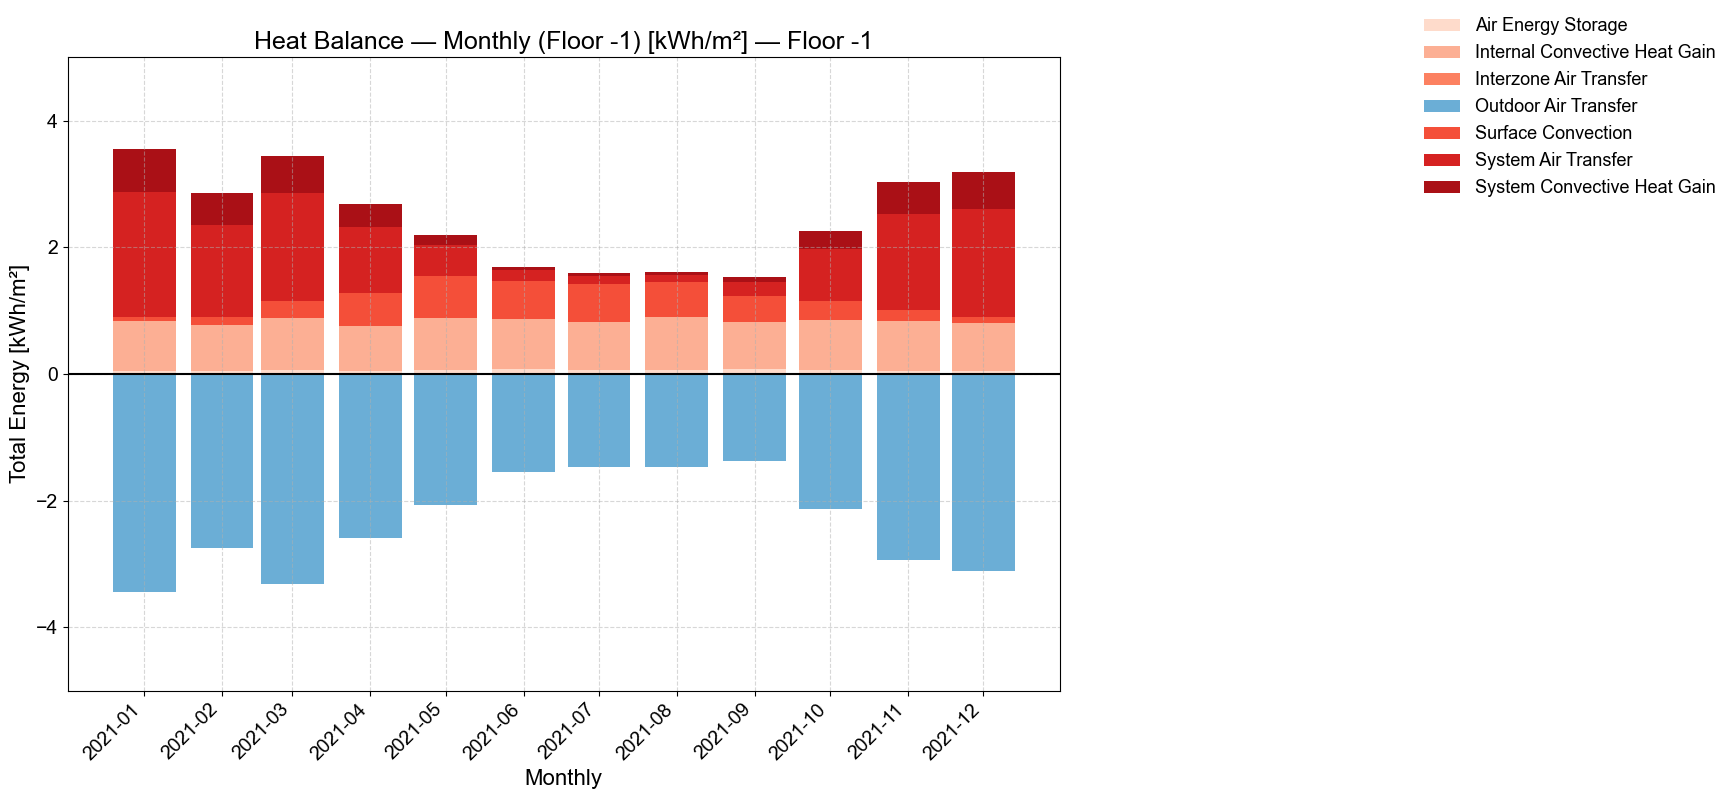

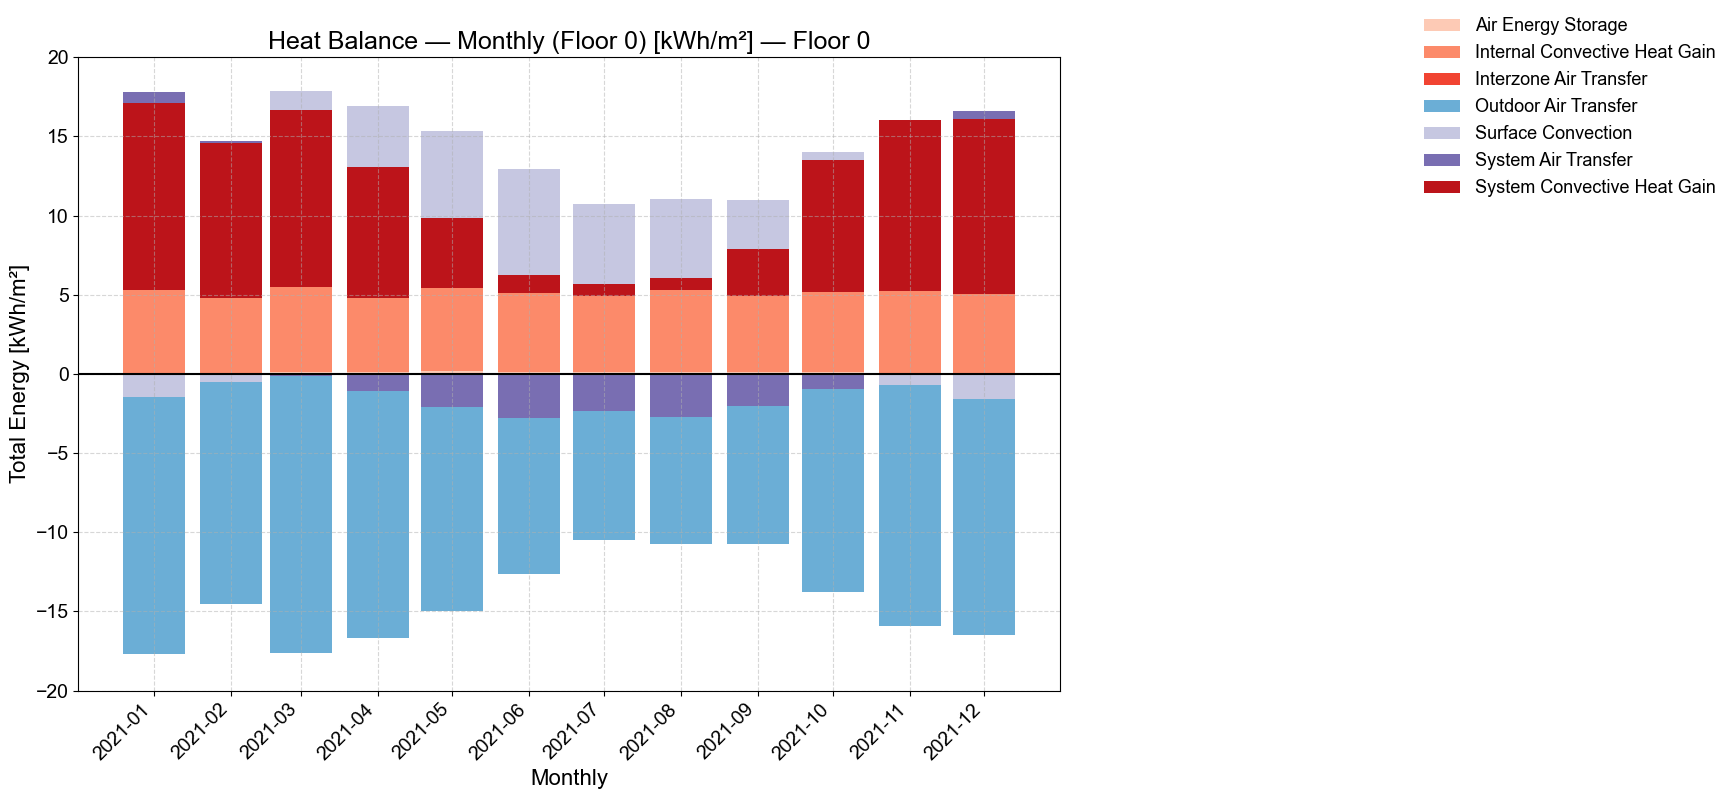

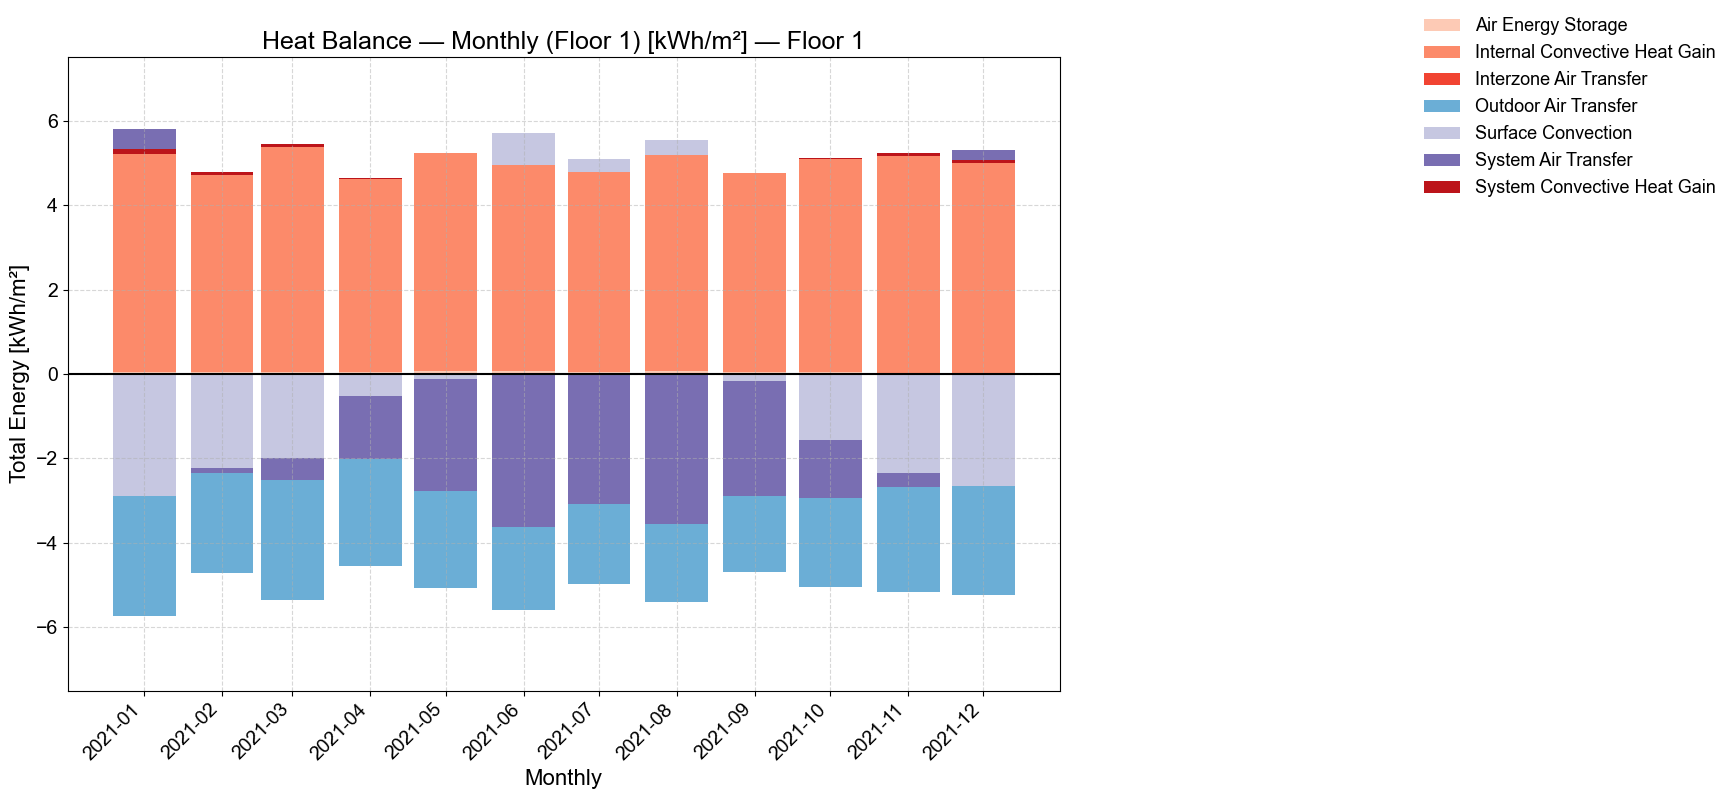

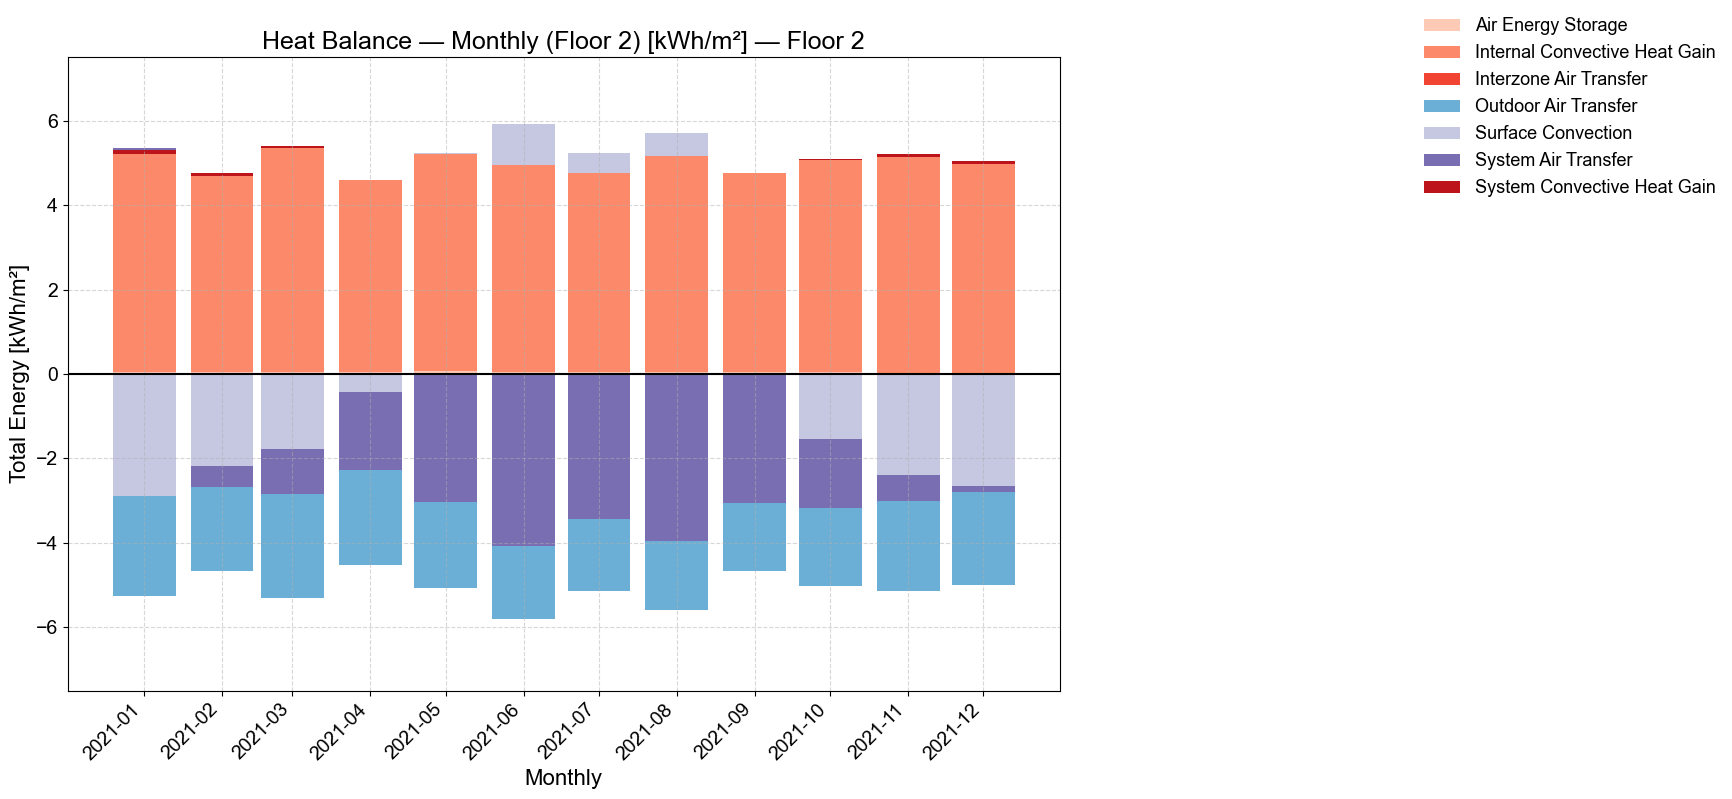

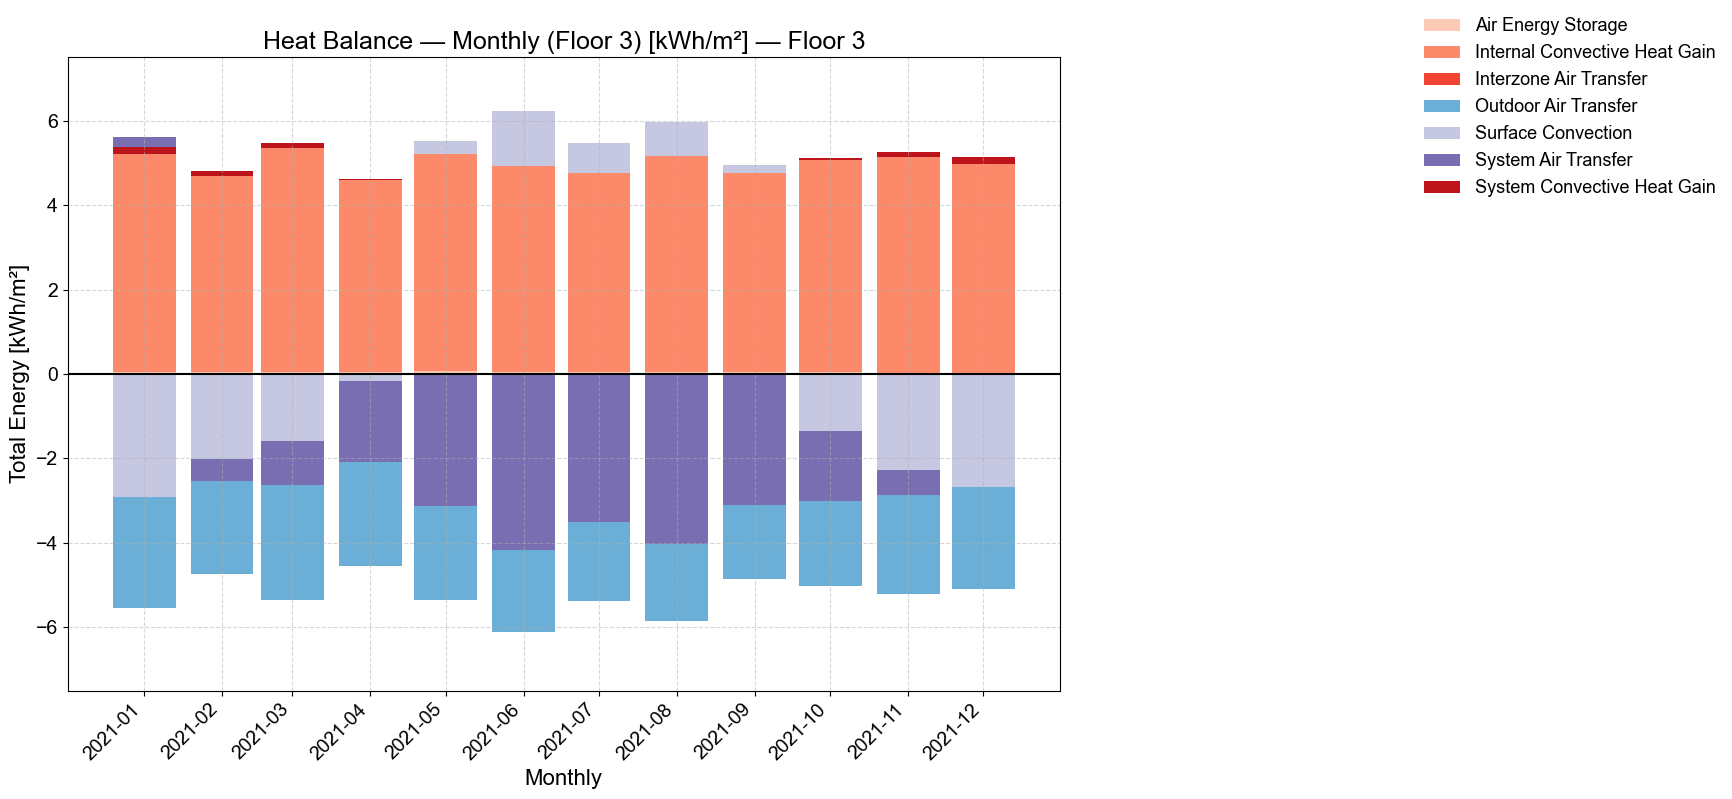

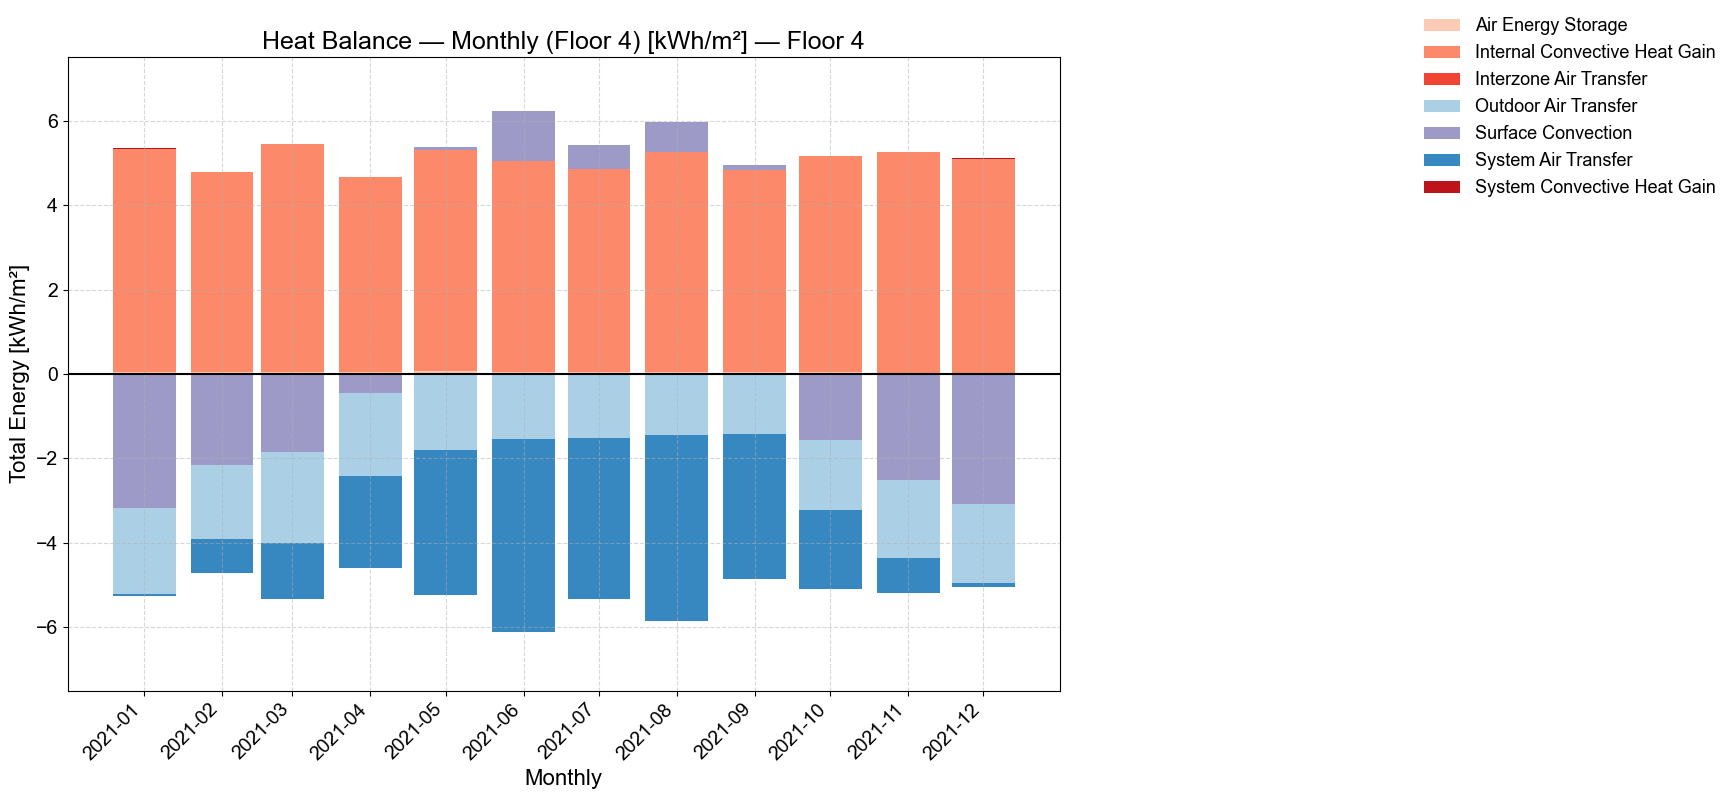

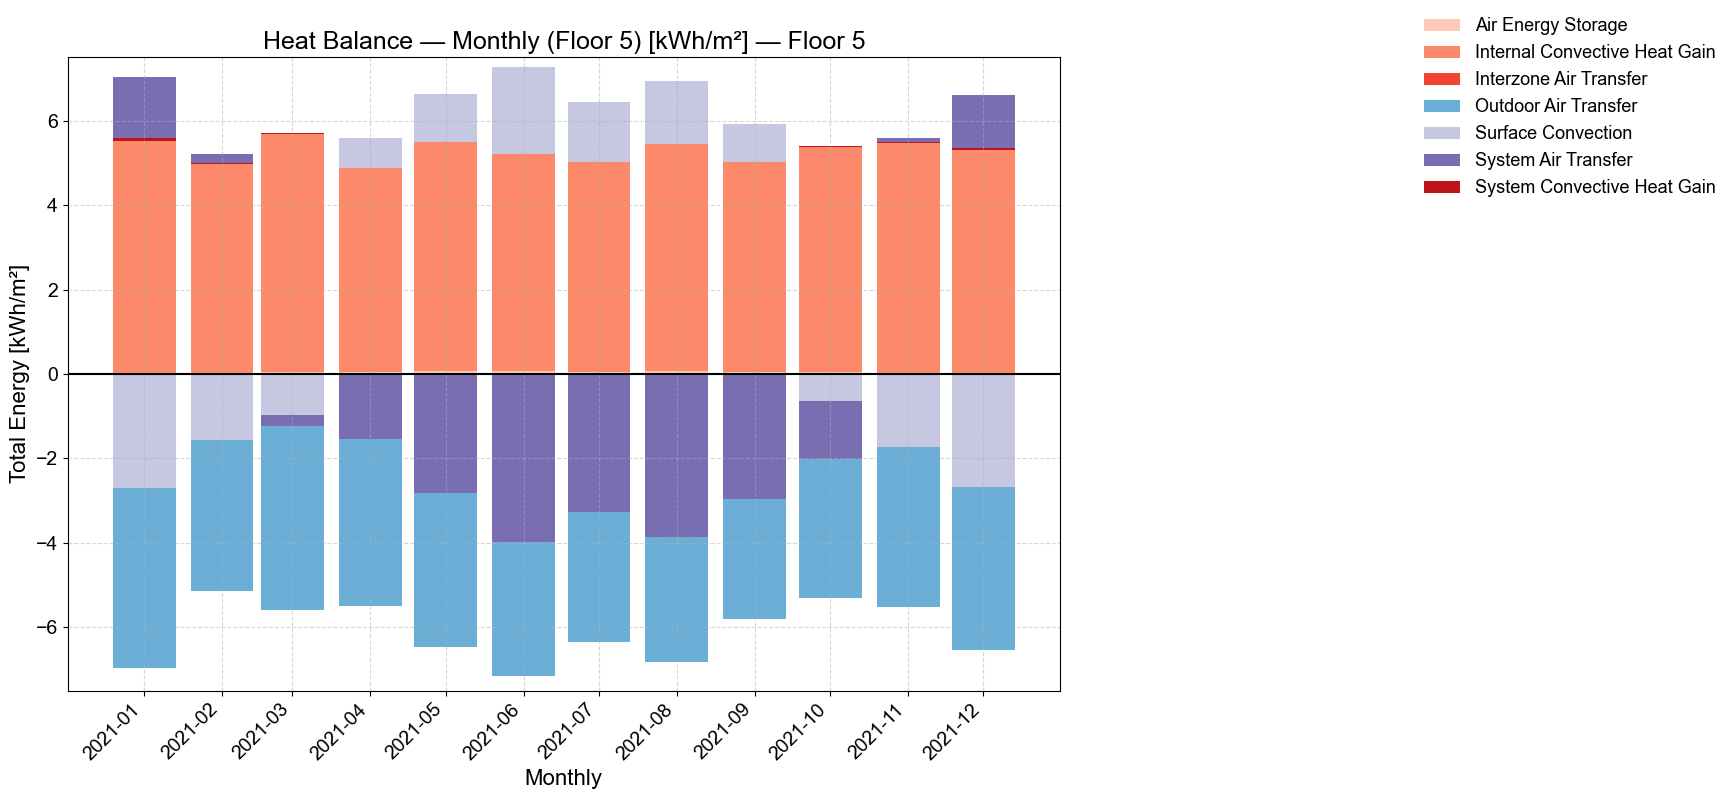

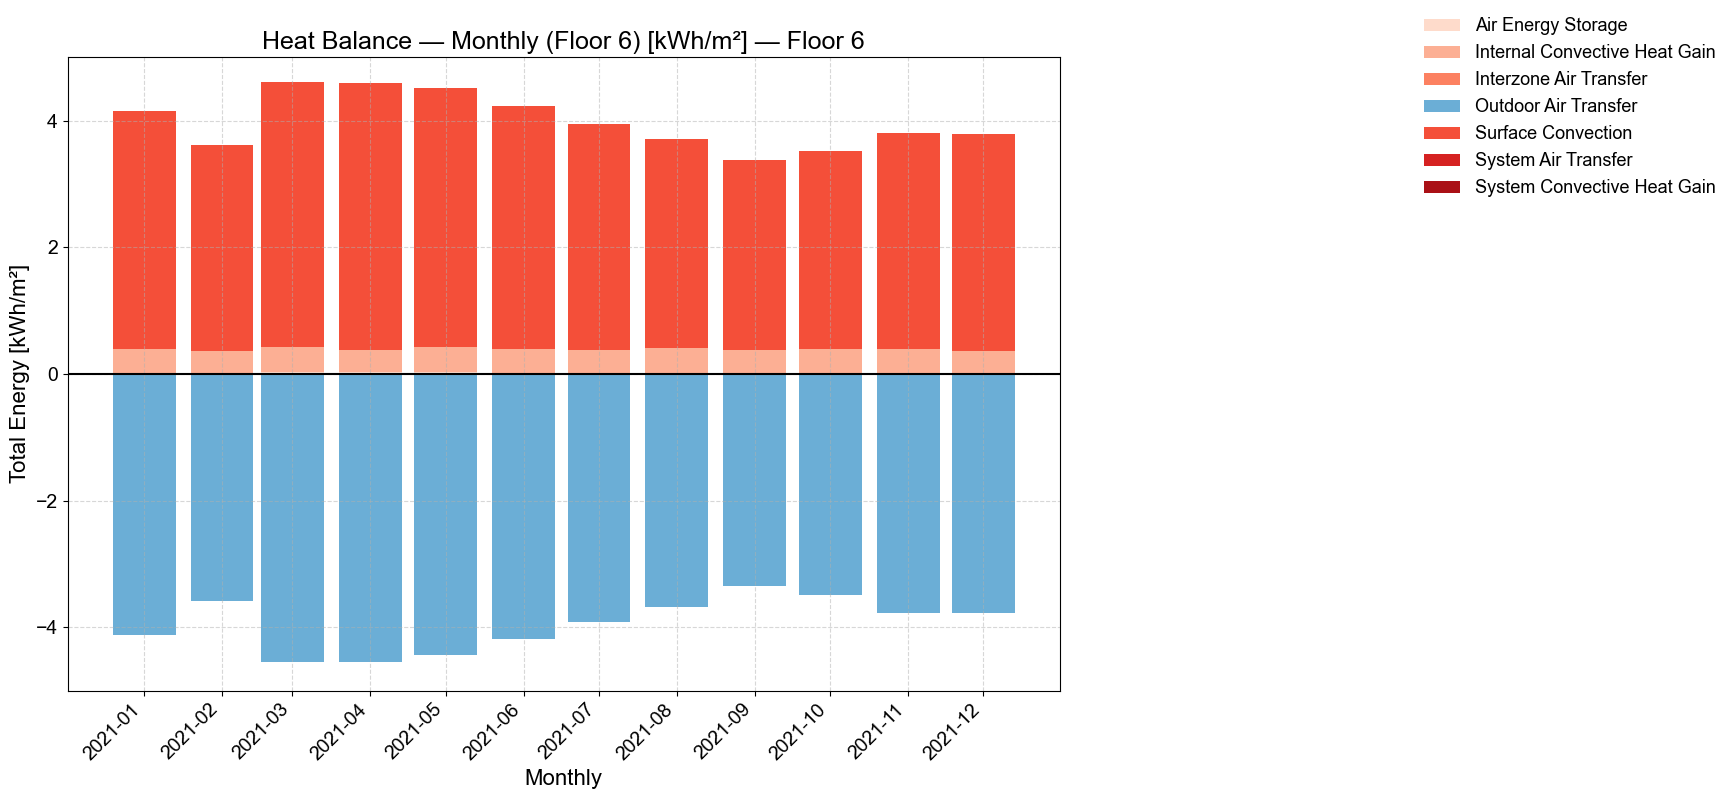

In [4]:
# Floors -1..6 (same colors)
for f in range(-1, 7):
    df_f = get_df(aggs, scale="monthly", scope="floor", floor=f,
                  units="kWh", per_m2=True, long_df_for_area=long_df)
    if df_f.empty:
        print(f"[Info] Floor {f} has no data.")
        continue
    plot_heat_balance(df_f, scale="monthly", scope=f"floor {f}",
                      units="kWh", per_m2=True, global_color_map=global_colors,
                      title_suffix=f"— Floor {f}")